# YNet - Dataset v5.1 and v5.2:

Data from Experiment (1) and (2), Mitochondria = Cit1-mCherry 

### Importing utilities:

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

#### Setting up variables

In [3]:
PATH = "datasets/yeast_v5.2/"
data_path = Path(PATH)

In [4]:
CLASSES = ('WT', 'mfb1KO', 'mmr1KO', 'mmm1KO', 'num1KO' )
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = 200

In [ ]:
!ls ..

#### Calculating normalization statistics

In [5]:
stats_name = "yeast_v5.2_per_class.dict"
classes = Statistics.source_class(data_path)

train_val = zip(classes['train'], classes['val'])
Xtest = zip(classes['test'])
 
main_stats = Statistics.per_class(train_val, save_name=stats_name)
test_stats = Statistics.per_class(Xtest, save_name=stats_name)

working on: mfb1KO
working on: mfb1KO
working on: mmm1KO_230
working on: mmm1KO_230
working on: mmr1KO
working on: mmr1KO
working on: num1_110
working on: num1_110
working on: WT
working on: WT
working on: mfb1KO_mmr1KO


In [6]:
for keys in main_stats.keys():
    print(f"{keys}: \t \t \t {main_stats[keys]}")

mfb1KO: 	 	 	 (array([0.01453, 0.00456]), array([0.00668, 0.00142]))
mmm1KO_230: 	 	 	 (array([0.02099, 0.00428]), array([0.00144, 0.00242]))
mmr1KO: 	 	 	 (array([0.01455, 0.00484]), array([0.0067 , 0.00177]))
num1_110: 	 	 	 (array([0.02101, 0.005  ]), array([0.00147, 0.0022 ]))
WT: 	 	 	 (array([0.01435, 0.00464]), array([0.00668, 0.0014 ]))


In [7]:
for keys in test_stats.keys():
    print(f"{keys}: \t \t \t {test_stats[keys]}")

mfb1KO_mmr1KO: 	 	 	 (array([0.0079 , 0.00474]), array([0.00073, 0.00153]))


## Defining datasets:

In [12]:
def tfms_for_test(stats, sz):
    test_norm = Normalize(stats)
    test_denorm = Denormalize(stats)
    val_crop = CropType.NO
    test_tfms = image_gen(test_norm, test_denorm,sz, crop_type=val_crop)
    return test_tfms

In [13]:
def get_data(path: str, sz, bs):
    create, lbl2index, test_lbl2index = ImageClassifierData.prepare_from_path(path, val_name='val',test_name='test', test_with_labels=True, bs=bs)
    main_stats_X = {lbl2index[key]: val for key, val in main_stats.items()}
    test_stats_X= {test_lbl2index[key]: val for key, val in test_stats.items()}

    tfms = tfms_from_stats(main_stats_X, sz, aug_tfms=[RandomDihedral()], pad=sz//8)
    test_tfms = tfms_for_test(test_stats_X,sz) # change test_stats to test_stats_X to use lbl2index version
    tfms += (test_tfms, )
    print('\n class to index mapping:\n',lbl2index)
    print('\n test class to index mapping:\n',test_lbl2index)
    return create(tfms)


In [14]:
data = get_data(PATH,SIZE, BATCH_SIZE)

datasets/yeast_v5.2/ {}
datasets/yeast_v5.2/ {'WT': 0, 'mfb1KO': 1, 'mmm1KO_230': 2, 'mmr1KO': 3, 'num1_110': 4}
datasets/yeast_v5.2/ {}

 class to index mapping:
 {'WT': 0, 'mfb1KO': 1, 'mmm1KO_230': 2, 'mmr1KO': 3, 'num1_110': 4}

 test class to index mapping:
 {'mfb1KO_mmr1KO': 0}


In [18]:
x, y = next(iter(data.trn_dl))

In [19]:
test_x, test_y = next(iter(data.test_dl))

### Inspect loaded data:

C:\Anaconda3\envs\fastai\lib\site-packages\matplotlib\axes\_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))
C:\Anaconda3\envs\fastai\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Anaconda3\envs\fastai\lib\site-packages\matplotlib\axes\_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


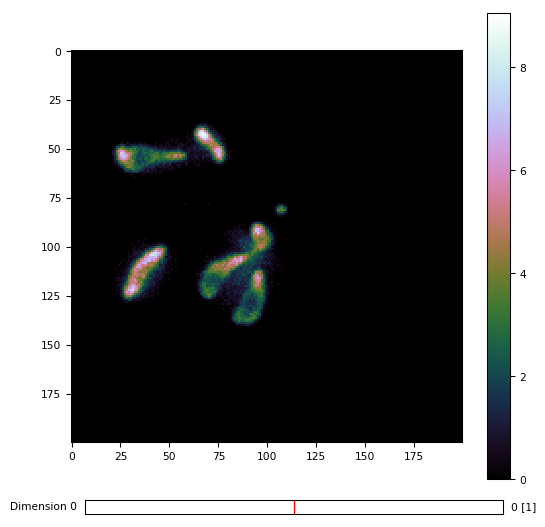

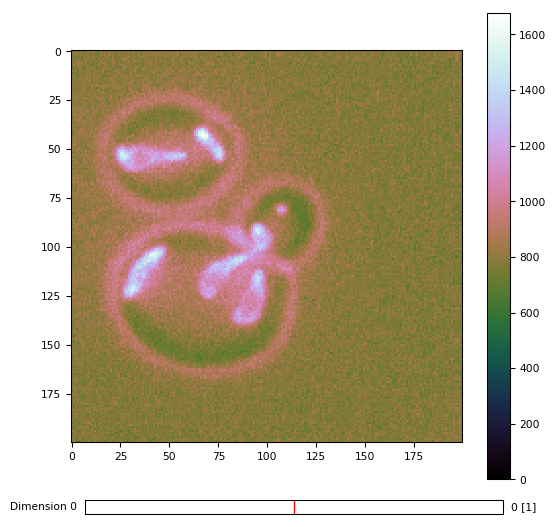

In [22]:
# specify which image-index
idx = 31

# loading it from GPU to CPU
xx = x[idx].cpu().numpy().copy()
yy = y[idx]
# showing the image
#
#sp.axis('Off')
#sp.set_title("Norm", fontsize=11)
figure, _ ,_ = tiff.imshow(np.sum(xx, axis=0))
figure.set_size_inches(6,6)
figure.add_subplot(111)

figure2, _, _ = tiff.imshow(np.sum(data.trn_ds.denorm(xx,yy).squeeze() * 65536, axis=2))
figure2.set_size_inches(6,6)


# Training setup

In [23]:
torch.cuda.is_available()

True

## ResNet_with_Batchnorm

In [ ]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [ ]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [ ]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
wd=1e-5

In [ ]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 6), data)

In [ ]:
learn.summary()

In [ ]:
%time learn.fit(1e-2, 8, cycle_len=1, wds=wd)

In [ ]:
# at very little overfitting we have 43% accuracy
%time learn.fit(1e-2, 8, wds=wd, cycle_len=10, use_clr=(20,8, 0.95, 0.85))

In [ ]:
%time learn.fit(1e-3, 2, wds=wd, cycle_len=20, use_clr=(20,8, 0.95, 0.85))

In [ ]:
%time learn.fit(1e-3, 2, wds=wd, cycle_len=20, use_clr=(20,8, 0.95, 0.85), best_save_name='YNet_Res_v5_redo_1')

### Show loss over time

In [ ]:
f = plt.figure()
x = learn.sched.plot_loss()
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.show()

## Analysis

### ...after training 

In [ ]:
## Load model:
learn.load('Objective_A_Resnet_per_class_2')

In [ ]:
%time learn.fit(1e-10, 1, wds=wd, cycle_len=1)

In [ ]:
log_preds, y = learn.TTA() # run predictions with TTA

### Confusion matrix

In [ ]:
# Plot confusion matrix 
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)

### Analyse images 

#### Show random correct/incorrectly classified images:

In [ ]:
log_preds_mean = np.mean(log_preds, axis=0) # averages predictions on original + 4 TTA images
preds = np.argmax(log_preds_mean, axis=1) # converts into 0 or 1

In [ ]:
# probs = np.exp(log_preds_mean[:,0]) # prediction(WT)
probs = np.exp(log_preds_mean) # predictions

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [ ]:
def plots(ims, channel, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=11)
        if channel is not None: plt.imshow(ims[i,channel,:,:]) 
        else: plt.imshow(np.sum(ims, axis=1)[i,:,:])

In [ ]:
def plot_val_with_title_from_ds_no_denorm(idxs, title, channel=None):
    
    imgs = np.stack(data.val_ds[x][0] for x in idxs) # get images by idx
    corr_lbl = np.stack(data.val_ds[x][1] for x in idxs) # get correct label from data.val_ds by idx
    pred_lbl = np.stack(preds[x] for x in idxs) # get predicted label from preds by idx
    p_max = [np.amax(probs[x,:]) for x in idxs] # get highes probability from probs by idx
    
    title_fin = [f"true = {corr_lbl[x]}\n predicted: {pred_lbl[x]}\n  p = {p_max[x]}" for x in corr_lbl]
    print(title)
    
    return plots(imgs, channel, rows=1, titles=title_fin, figsize=(16,8))

### Plot images according to predictions

In [ ]:
# load from ds - not denormalized! 
plot_val_with_title_from_ds_no_denorm(rand_by_correct(True), "Correctly classified")
#optionally pass channel arg. to select single channel

In [ ]:
plot_val_with_title_from_ds_no_denorm(rand_by_correct(False), "Incorrectly classified")

#### Show most correct/incorrectly classified images per class:

In [ ]:
def most_by_mask(mask, y, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[:,y][idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), y, mult)

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, True), "Most correctly classified WT")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, False), "Most incorrectly classified WT") # logic?

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, True), "Most correctly classified mfb1KO") 

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, False), "Most incorrectly classified mfb1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(2, True), "Most correctly classified mfb1KO-mmr1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(3, True), "Most correctly classified mmr1KO")

In [ ]:
# etc.

#### Show (most) uncertain images

In [ ]:
most_uncertain = t = np.argsort(np.amax(probs, axis = 1))[:6] # get best "guess" per image and list the least confident ones
plot_val_with_title_from_ds_no_denorm(most_uncertain, "Most uncertain predictions")

# DOES THE MODEL GENERALIZE?????

In [ ]:
def get_test_data(path: str, sz, bs):
    create, lbl2index = ImageClassifierData.prepare_from_path(path, val_name='val', test_name='test', test_with_labels=True, bs=bs)
    main_stats_X = {lbl2index[key]: val for key, val in main_stats.items()}
    test_stats_X= {lbl2index[key]: val for key, val in test_stats.items()}
    tfms = tfms_from_stats(main_stats_X, sz, aug_tfms=[RandomDihedral()], pad=sz//8) #even without transformations and padding -> failure
    test_tfms = tfms_for_test(test_stats_X,sz)
    tfms += (tfms[0], )
    print('\n class to index mapping:\n',lbl2index)
    return create(tfms)

In [ ]:
test_data = get_test_data(PATH,SIZE, BATCH_SIZE)

In [ ]:
test_learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 4), test_data)

In [ ]:
test_learn.load('Objective_A_Resnet_per_class_2')

In [ ]:
test_learn.warm_up(1e-14)

In [ ]:
test_log_preds, targs = test_learn.predict_with_targs(is_test=True)
testprobs = np.exp(test_log_preds)
preds = np.argmax(testprobs, axis=1)
print(preds)
print(targs)

In [ ]:
# Print Accuracy
print(f"accuracy: [{sum(preds == targs) / 70:4.4}]")

In [ ]:
test_log_preds

### Troubleshooting:

In [ ]:
test_x , test_y = next(iter(test_data.test_dl))

In [ ]:
# specify which image-index
idx = 2

# loading it from GPU to CPU
test_xx = test_x[idx].cpu().numpy().copy()
test_yy = test_y[idx]

figure, _ ,_ = tiff.imshow(np.sum(test_xx, axis=0))
figure.set_size_inches(6,6)
figure.add_subplot(111)

figure2, _, _ = tiff.imshow(np.sum(xx, axis=0))
figure2.set_size_inches(6,6)


## Caclulating normalization statistics separately

In [ ]:
for keys in main_stats.keys():
    print(f"{keys}: \t \t \t {main_stats[keys]}")

In [ ]:
for keys in test_stats.keys():
    print(f"{keys}: \t \t \t {test_stats[keys]}")

In [ ]:
## Load model:
learn.load('Objective_A_Resnet_per_class_2')

In [ ]:
%time learn.fit(1e-10, 1, wds=wd, cycle_len=1)

In [ ]:
test_log_preds, targs = learn.predict_with_targs(is_test=True)
testprobs = np.exp(test_log_preds)
preds = np.argmax(testprobs, axis=1)
print(preds)
print(targs)

In [ ]:
# Print Accuracy
print(f"accuracy: [{sum(preds == targs) / 140:4.4}]")

In [ ]:
test_log_preds